# **A Comparative Evaluation of ARIMA, SARIMA, and XGBoost Models for India’s CPI Inflation Forecasting**





# **Sections**

## **Section 1: Introduction**
## **Section 2: Data Preparation and Visualization**
## **Section 3: Seasonality Tests**
### **Section 3.1. Data Preparation**
### **Section 3.2. Preliminary Seasonality Tests Using STL and ACF**
### **Section 3.3. Final Seasonality Test - CH Test**
## **Section 4: 10-year Forecast**
### **Section 4.1. 10-year Forecast: Pre-COVID Regime**
### **Section 4.2. 10-year Forecast: Pre and Post-COVID Regime**




---------------------------------------------------------------------------------------------------------------




## **Section 1: Introduction**
This notebook intends to analyze, compare and provide insights on the performance of three well known models (2 statistical and 1 machine learning) - ARIMA, SARIMA and XGBoost across the 3 parameters specifically answering the following questions:

1. In-Sample: How well the model describes and fits the training data - measured using log-likelihood, AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion) and p-values of model coefficients - for the 2 statistical models only.
2. Out-of-Sample: How well the model forecasts previously unseen data (test data) - measured using RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) - across all 3 models.
3. Viability of Long-Run Forecasts: How economically plausible or structurally meaningful the long-run forecasts appear - assessed using qualitative and contextual judgment, given the absence of exogenous macroeconomic drivers.

Additionally, the notebook explains the underlying engine - both mathematically and intuitively - of each model - to provide the reader with a clear understanding of what goes on under the hood for each model.

The analysis uses the official All-India Consumer Price Index (CPI – Combined) year-on-year (YoY) inflation series published by the Ministry of Statistics & Programme Implementation (MoSPI), Government of India. MoSPI’s CPI (Base Year 2012 = 100) is the standard measure of retail price inflation and is released monthly through the National Statistical Office (NSO) press-release annexures.


**Dataset Description:**

The dataset employed here spans January 2014 through August 2025 and provides the monthly percentage change in the General CPI over the corresponding month of the previous year. Two calendar years—2020 and 2021—have been excluded from the dataset due to lack of availability from credible sources. These years coincide with the peak of the COVID-19 pandemic, when India experienced:

1. Unprecedented supply-chain disruptions and demand shocks,
2. Nation-wide lockdowns and abrupt changes in consumption patterns, and
3. Gaps in official data collection, with MoSPI itself noting that CPI for April–May 2020 could not be compiled.

Since these events constitute a structural break that would bias the estimation of long-run seasonal and trend dynamics if left unadjusted, this notebook looks at two regimes of data:

1. Pre-COVID - 2014 to 2019
2. Full Dataset - 2014 to 2025 - with imputed data for the periods of 2020 and 2021 (using STL to ensure the imputed data - at minimum - absorbs the seasonality and trend of the overall dataset)

**Modelling Approach:**

Subsequent sections of this notebook outline the data-preparation steps, stationarity diagnostics, and the implementation of: 

- Two classical time-series models—specifically ARIMA/SARIMA variants and, 
- One supervised ML model (XGBoost)

These models are used to generate monthly forecasts of India’s headline inflation for the next 120 months (2025–2035). These projections are then evaluated to compare each model’s long-run behavior, stability, and economic viability.

**DISCLAIMER:** This notebook is solely for comparative and research purposes, and does **NOT** intend to conclusively determine long-run forecasts for any form of financial/ economic interpretation. Accurate long run forecasts require the presence of multiple exogenous variables that have not been considered as part of this research. Hence, long-horizon projections should be interpreted as indicative - rather than definitive.

In [1]:
# Importing necessary packages for the model
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
from pmdarima.arima import CHTest
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
warnings.simplefilter("ignore", category=FutureWarning)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb

## **Section 2: Data Preparation and Visualization**
This section shows a visual representation of the inflation data - as sourced from MoSPI.

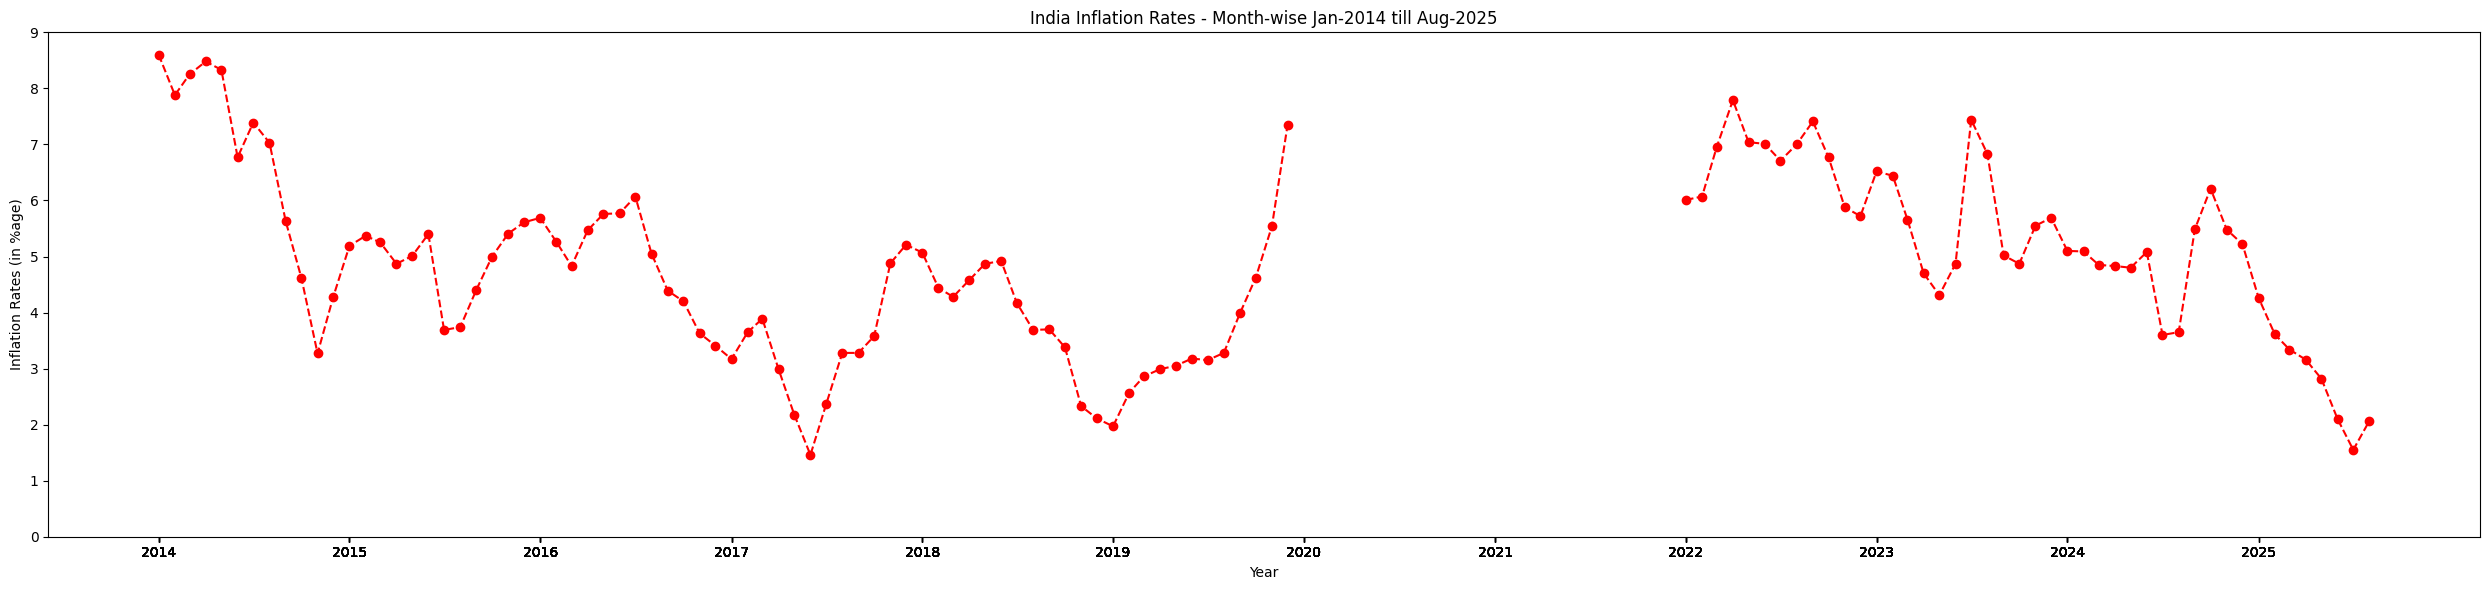

In [2]:
# Initialize environment and set conditions
load_dotenv()
inflation_dataset = os.getenv('inflation_dataset')
forecast_pre_dataset = os.getenv('forecast_pre_dataset')
forecast_imputed_dataset = os.getenv('forecast_imputed_dataset')
sarima_forecast_imputed_dataset = os.getenv('sarima_forecast_imputed_dataset')
xgboost_forecast_imputed_dataset = os.getenv('xgboost_forecast_imputed_dataset')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load data
df_inflation = pd.read_csv(inflation_dataset)
X_values = [dt.strptime(d, '%m/%d/%Y') for d in df_inflation['Date']]
Y_values = df_inflation['CPI_Inflation_YoY_Percent'].to_list()
Y_ticks = [round(i) for i in range(int(max(Y_values)+2))]
X_ticks = [dt.strftime(d, '%Y') for d in X_values]

# Visualize data
fig, ax = plt.subplots(figsize=(25, 6), dpi=100)
ax.plot(X_values, Y_values, '--', color='red', marker='o')
ax.set_title('India Inflation Rates - Month-wise Jan-2014 till Aug-2025')
ax.set_xlabel('Year')
ax.set_ylabel('Inflation Rates (in %age)')
ax.set_xticks(X_ticks)
ax.set_yticks(Y_ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

# Generate dataset for next stage
df_seasonality_test_data = pd.DataFrame()
df_seasonality_test_data['Period'] = X_values
df_seasonality_test_data['Inflation_rates'] = Y_values


## **Section 3: Seasonality Tests**
This section uses decomposition and autocorrelation diagnostics to determine if the series has a recurring seasonal pattern and whether seasonal differencing is required before modeling.

Typical workflow for seasonality tests to gauge presence/ strength of seasonality is as follows:
1. **Conduct STL (Seasonal Trend Decomposition with LOESS), and determine Hyndman score**, for initial view of seasonality strength on the dataset. While this statistic gives an explanation on how much of the variance is explained by the seasonal component, it does not prescribe model differencing.
2. **Perform ACF (Autocorrelation Function) analysis** with a sensible maximum lag (e.g. 48 for monthly data). By performing a visual inspection of the output, we can identify significant spikes at multiples of the seasonal period (e.g., 12, 24, etc.). ACF at lag ($k$) is the Pearson Correlation between $X_t$ and $X_{t-k}$ **across all $t$**. Regular spikes at multiples of seasonal period ($s$) indicate seasonal dependence.
3. **Perform CH (Canova-Hansen) test** to conclusively determine the need and value of seasonal differencing.

Since our dataset is devoid of the 2020-21FY data, we have split the raw dataset into two regimes:
1. Regime 1: Pre-COVID dataset - for performing seasonality tests on the pre-COVID regime. Here, we have considered **lag=48 (4 years)** since we have data from Jan-2014 till Dec-2019.
2. Regime 2: Post-COVID dataset - for performing seasonality tests on the post-COVID regime. Here, we have considered **lag=24 (2 years)** since we have data from Jan-2022 till Aug-2025.

Seasonality tests will be performed on each dataset separately and final conclusions on scenario development shall be determined based on these conclusions.

### **3.1. Data Preparation:**
This section focuses on preparing the necessary datasets for running seasonal decomposition analysis and seasonality strength tests.

In [3]:
# Generating pre-COVID data for seasonality tests
df_seasonality_test_data_pre = df_seasonality_test_data[
    df_seasonality_test_data['Period']<'2020-01-01'
    ]
df_seasonality_test_data_pre.set_index('Period', inplace=True)
df_seasonality_test_data_pre = df_seasonality_test_data_pre.asfreq('MS')

### **3.2. Preliminary Seasonality Tests Using STL and ACF**
This section performs seasonal decomposition and seasonality strength tests on the pre-COVID and post-COVID datasets. STL (with the additive model) and the subsequent Hyndman score (along with ACF) have been used to establish the rpesence of seasonality in the two regimes and measure its strength in each.

#### **About STL:**
#### STL: Seasonal–Trend decomposition using Loess
**STL** stands for **Seasonal–Trend decomposition using Loess** (a.k.a. LOWESS: *LOcally WEighted Scatterplot Smoothing*). **LOESS** is a non-parametric smoothing technique that fits many small local regressions around each data point to generate a smooth curve without assuming a global formula and hence, in the context of this analysis, is a better alternative to exponential smoothing or weighted moving average, due to its ability to offer more flexible trend extraction.

**Model Explanations (selected model: additive)**
For an additive decomposition:
$$
y_t = T_t + S_t + R_t,
$$
where $$T_t = trend, S_t = seasonal component, R_t = remainder (noise).$$

For multiplicative behavior, use a log transform and decompose additively:
$$
\log y_t = T_t + S_t + R_t \quad \iff \quad y_t = e^{T_t}\cdot e^{S_t}\cdot e^{R_t}.
$$

**How STL works**

In simple terms, STL splits the raw dataset into 3 components:
1. **Trend** - this component outlines ONLY the underlying trend demonstrated by the raw data (sans the impact of seasonality and residuals).
2. **Seasonal** - this component outlines ONLY the seasonality that is baked into the raw data (sans the trend and residuals).
3. **Residuals** - this component outlines what is left in the raw data - after extracting the trend and seasonality from the same.

Below is a more detailed overview of STL:
1. **Seasonal extraction (cycle–subseries smoothing)**  
   For lag ($k$) (e.g., 12, 24, etc.), split the series into $k$ subseries by season (all Januaries, all Februaries, …) and smooth each subseries with LOESS to get a preliminary $\tilde{S}_t$.
2. **Low-pass filtering of seasonal**  
   Smooth $\tilde{S}_t$ again (moving averages + LOESS) so seasonality changes **slowly** over time.
3. **Trend extraction**  
   Detrend input via $y_t - S_t$, then smooth with LOESS to obtain $T_t$.
4. **Robust reweighting (optional but standard)**  
   Compute residuals $r_t = y_t - T_t - S_t$. Form robustness weights using a bisquare function on scaled residuals (MAD scale):
   $$
   u_t = \frac{r_t}{6\,\mathrm{MAD}(r)},\qquad
   b_t =
   \begin{cases}
   (1-u_t^2)^2,& |u_t|<1\\
   0,& \text{otherwise}
   \end{cases}
   $$
   Re-run seasonal & trend smoothing with weights multiplied by $b_t$ to **down-weight outliers**.
5. **Iterate**  
   STL alternates seasonal ↔ trend updates (inner loop) and robustness updates (outer loop) until changes are small.

**Pros vs. Cons**

**Pros**
- Works for **any seasonal period \(m\)** (not just 12/4).
- Allows **seasonality to evolve** over time.
- **Robust** to outliers (with `robust=True`).
- Transparent smoothness controls: `s.window` (seasonal), `t.window` (trend).

**Cons**
- Requires a **regular, gap-free** series (hence the raw data set has been split into pre and post-COVID data and separate STL tests have been performed on each).
- Window choices affect results (not a single “correct” setting).
- Descriptive method—no built-in forecasting (forecast components or the remainder with a model).

**Additive vs. multiplicative?**
- If seasonal amplitude is roughly **constant** - which is typically the case for inflation rates, use **additive**.
- If amplitude **scales with the level** - typically seen in revenue, sales data, decompose **log(y)** additively (equivalently multiplicative on \(y\)).

**Quantifying seasonal strength (Hyndman score)**
A handy indicator (0 = none, →1 = strong):
$$
\text{Strength} = \max\left(0,\; 1 - \frac{\mathrm{Var}(R)}{\mathrm{Var}(R+S)}\right).
$$
Higher values mean stronger seasonality.

#### **Seasonal Decomposition of pre-COVID regime:**

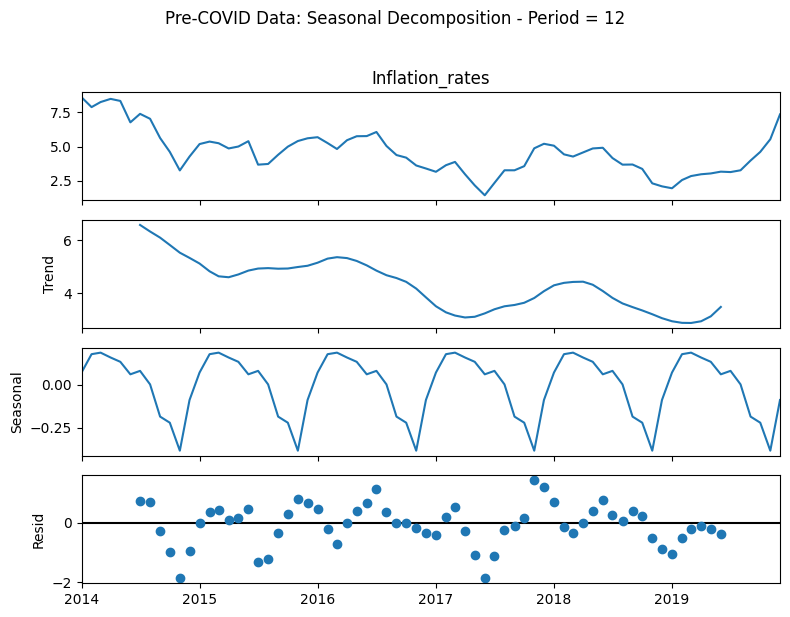

Pre-COVID data seasonality strength: 0.10
Pre-COVID data assessment based on Hyndman score:
Low seasonality strength


In [4]:
# Seasonal decomposition for pre-COVID data (Aug-2014 till Dec-2019)
series_pre = df_seasonality_test_data_pre['Inflation_rates']
seasonal_decomp_pre = seasonal_decompose(series_pre, model='additive', 
                                         period=12)
fig_pre = seasonal_decomp_pre.plot()
fig_pre.set_size_inches(8, 6)
fig_pre.suptitle('Pre-COVID Data: Seasonal Decomposition - Period = 12', 
                 fontsize=12, y=1.02)
fig_pre.tight_layout()
plt.show()

# STL for seasonality strength
stl_pre = STL(series_pre, period=12, robust=True).fit()
T_pre, S_pre, R_pre = stl_pre.trend, stl_pre.seasonal, stl_pre.resid

# Hyndman seasonality strength score
strength_pre = max(0, (1 - (R_pre.var() / (R_pre.var() + S_pre.var() 
                                           + 2 * R_pre.cov(S_pre)))))
print(f'Pre-COVID data seasonality strength: {strength_pre:.2f}')
print('Pre-COVID data assessment based on Hyndman score:')
if strength_pre > 0 and strength_pre <= 0.3:
    print('Low seasonality strength')
else:
    print('High seasonality strength')

#### **Interpretation of STL analysis on pre-COVID regime:**
As evidenced from the STL decomposition, while the pre-COVID regime dataset does depict presence of seasonality, its strength is quite low (as evidenced based on the corresponding Hyndman Score). This means that while seasonal differencing can be factored into the dataset, based on interpretation of just the STL analysis, the same is not warranted. Additional ACF analysis and subsequent CH test results (as presented in the subsequent sections of this document) will provide better insights on the same.

#### **About ACF**
#### ACF: Autocorrelation Function
**ACF** measures linear correlation between a time series and **lagged** versions of itself. I.e., for lag $k$, it asks “how similar is $y_t$ to $y_{t-k}$?”

**How ACF works (high-level)**

In simple terms, ACF plots the correlation between the value of a series ($y_i$) at time $t$ and its value at time $t-k$ or $k$ periods earlier. The result (when applied across all data points in a series $Y$), gives us a graph that plots the correlations (vertical bars) between value of the series at time $t$ and value of the same series at time $t-k$ and the ±1.96/√n bands (shaded area). If this graph displays an oscillating pattern that shows significant spikes - repeating periodically (i.e. beyond the ±1.96/√n bands) - then we can conclude (with 95% confidence, if alpha = 5%) that seasonality is present in the raw data.

Below is a more detailed overview of ACF:

1. **Determine autocovariance**:
    For a weakly stationary series (i.e., a series of data whose mean $\mu$ and variance $\sigma^2$ do not change over time) $Y$, with mean $\mu$ and variance $\sigma^2$, determine the **autocovariance** at lag $k$, given as:

    $$
    \gamma(k) \;=\; \operatorname{Cov}(y_t,\; y_{t-k})
    \;=\; \mathbb{E}\!\big[(y_t-\mu)(y_{t-k}-\mu)\big].
    $$

    which measures the covariance between today’s value $y_t$ and the value $k$ time steps earlier ($y_{t-k}$).

2. **Determine autocorrelation**: 
    The **autocorrelation** at lag $k$ for the series $Y$ is then determined using:

    $$
    \rho(k) \;=\; \frac{\gamma(k)}{\gamma(0)} \;=\; \frac{\gamma(k)}{\sigma^2}.
    $$

    which normalizes the covariance (by the variance) so the result is a pure correlation coefficient (i.e., values lie between -1 and 1).

**ACF application in real data**:
Since, in the case of real data, we do not know the true mean or true expected values, we typically use the **sample ACF** method; given using the equation:

$$
\hat{\rho}(k)
\;=\;
\frac{\sum_{t=k+1}^{n}(y_t-\bar y)(y_{t-k}-\bar y)}
     {\sum_{t=1}^{n}(y_t-\bar y)^2},
$$

where $\bar y$ is the sample mean (which replaces the true mean) and $\sum$ is summation of the data (which replaces the expected values $\mathbb{E}$) 

**Interpretation of ACF:**
- **Seasonality:** Significant spikes at **seasonal lags** (e.g., $12, 24, 36,\dots$ for monthly data).
- **Trend / non-stationarity:** ACF that **decays slowly** (stays high for many lags) → likely non-stationary → difference first.
- If the ACF shows spikes at $12, 24, …$ → seasonal dynamics present (consider **SARIMA**).
- If ACF decays slowly → **difference (and possibly seasonal difference)**.

**Significance & confidence bands**
Under the null hypothesis of white noise (i.e., zero mean, constant variance, and no predictable pattern), approximate 95 % confidence bands are:  (Bartlett’s formula provides a more exact variance):
$$
\pm \frac{1.96}{\sqrt{n}},
$$
for each individual lag. Bartlett’s formula provides an exact variance for these bands.
For statistical significance, we can use **Ljung–Box** to jointly test “no autocorrelation up to lag $k$” where if p-value < chosen significance level (e.g. 0.05), we reject $H_o$ $\rightarrow$ to conclude that there is significant autocorrelation somewhere among the first $k$ lags.

#### **ACF Analysis of pre-COVID regime:**

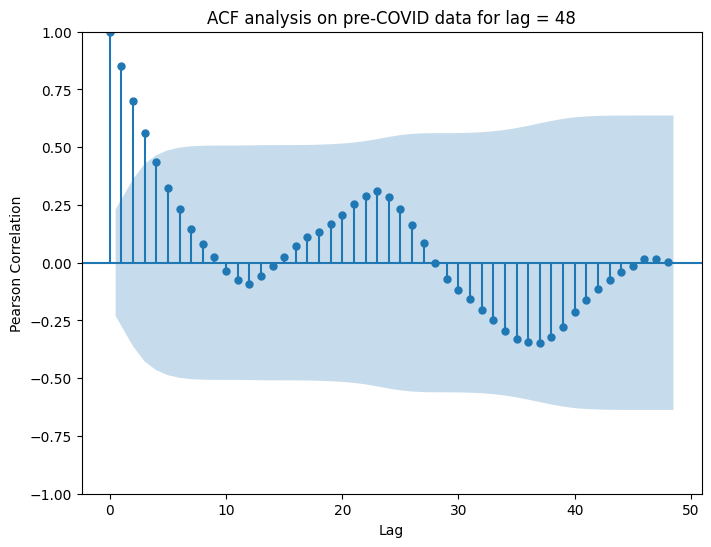

In [5]:
# ACF for pre-COVID data
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
plot_acf(series_pre, lags=48, ax=ax)
ax.set_title(f'ACF analysis on pre-COVID data for lag = 48')
ax.set_xlabel('Lag')
ax.set_ylabel('Pearson Correlation')
plt.show()

#### **Interpretaion of ACF analysis on pre-COVID regime**
An ACF plot of the pre-COVID regime dataset corroborates our findings from the STL analysis - i.e., while seasonality is present, its overall strength on the dataset is low - as evidenced from majority of the correlation peaks (vertical bars) falling within the confidence band (shaded region).

### **3.3. Final Seasonality Test - CH test**
This section uses the Canova-Hansen (CH) test to conclusively determine the presence of a seasonal unit root in both pre and post-COVID regimes. Based on the outcomes of this test, we will conclusively determine whether either, or both, regimes warrant seasonal differencing during forecasting - thereby allowing us to choose between ARIMA and SARIMA models.

#### **About CH:**
#### CH: Canova-Hansen Test
The **Canova–Hansen (CH)** test checks whether a time series contains a seasonal unit root—that is, whether a seasonal difference (e.g. a 12-month difference for monthly data) is needed to make the series stationary.

**Null ($H_0$) and Alternate ($H_1$) Hypothesis in CH Test**
- Null ($H_0$) Hypothesis: the series has a seasonal unit root $\rightarrow$ seasonal differencing needed - select SARIMA.
- Alternate ($H_1$) Hypothesis: the series does not contain a seasonal unit root $\rightarrow$ seasonal differencing not needed - proceed with ARIMA.

**Definition of Seasonal Root**

Presence of a seasonal unit root in a series means that seasonality in the dataset does not follow a repeating (osciallting) pattern. E.g., A monthly series whose January values have a mean that drifts over time rather than repeating around a constant seasonal mean.

**Practical Interpretation of Seasonal Root**

Presence of a seasonal unit root means that the data must be differenced at the seasonal lag to remove the stochastic seasonal component. After removing the seasonal component, the remaining series should be stationary and suitable for forecast modelling.

**How CH Test works**

In simple terms, a CH test performs a discrete Fourier Transform on seasonal regressons (sine, cosine pairs built on only the stochastic part of the dataset) called **Periodogram Ordinates** and takes a variance-weighted sum of these ordinates to determine the **Test Statistic**. The test statistic is then compared to critical values ($p_value$ < 0.05 or $p_value$ > 0.05) to determine the final decision on whether to accept or reject the **null hypothesis**.

#### **CH Test on pre-COVID regime:**

In [6]:
# CH Test on pre-COVID data
# Prep data
x_pre = series_pre.astype(float).to_numpy()

# Perfom test
ch_pre = CHTest(m=12)
D_pre = ch_pre.estimate_seasonal_differencing_term(x_pre)

# Print test result and decision
if D_pre > 1:
    print(f"""\nEstimated D for pre-COVID regime: {D_pre} 
          | Seasonal differencing needed --> 
          Select SARIMA for forecasting.""")
else:
    print(f"""\nEstimated D for pre-COVID regime: {D_pre} 
          | Seasonal differencing not needed --> 
          Proceed with ARIMA for forecasting.""")


Estimated D for pre-COVID regime: 0 
          | Seasonal differencing not needed --> 
          Proceed with ARIMA for forecasting.


## **Section 4: 10-year Forecast**
To recap, our inflation dataset was divided into two regimes:
1. Pre-COVID - showcasing the inflation during the preiod: Jan-2014 till Dec-2019.
2. Post-COVID - showcasing the inflation during the period: Jan-2022 till Aug-2025.

Our original dataset was segregated into the above regimes due to the lack of credible data during the COVID period (2020-21).

On each dataset we performed separate seasonality tests to determine whether seasonal differencing is needed or not and STL, ACF and finally CH Test were used to determine seasonal differencing. From our seasonality tests we have come to the conclusion that seasonal differencing on the data is not needed for forecasting and hence, our choice for forecasting inflation is **ARIMA (AutoRegressive Integrated Moving Average)**.

#### **About ARIMA:**

ARIMA is a time-series forecasting model. A model is called a time-series model when it satisfies the following three conditions:

- The model explicitly depends on time ordering - i.e., the model uses past values to predict future outcomes.
- The model captures temporal dependence - i.e., patterns such as persistence, autocorrelation and seasonality are central to how the model learns.
- The model forecasts future values by extrapolating time-based relationships.

ARIMA does not directly forecast the level of a variable. It first makes the data stationary (i.e., stabilizes the mean and variance of the data) by differencing the value in the current period from the value in the past period (e.g. if inflation in Jan-15 is 4.5% and inflation in Dec-14 is 4.2%, ARIMA will first capture the rate of change for the period (a.k.a discrete differencing) i.e. 0.3%. This is done by the "Integrated (I)" component of the model). Making the data stationary essentially removes the trend from the data and the reason why this is done is because the math behind AutoRegressive (AR) and Moving Average (MA) components assume that the data they are applied on is stationary. If not, AR and MA will generate error-prone results. Once the data has been made stationary, the AR and MA components apply the linear stochastic equation ("stochastic" since the error and intercept parameters are random variables determined using Maximum Likelihood Estimation) to forecast the change (not the actual inflation value but only the change). The forecasted change is then added to the last known value of inflation to determine the predicted inflation values (thereby incorporating the trend that was originally removed during the integrated stage).

**Additional Note - Difference between ARIMA and SARIMA:** In the above explanation of the ARIMA model we subtracted Dec-14 from Jan-15 to get the rate of change. Had our data demonstrated a seasonal root, and we would have used the SARIMA model - instead of ARIMA, this differencing would be Jan-14 from Jan-15 - to account for seasonality in the data. Thus, the fundamental difference between ARIMA and SARIMA is how seasonality is accounted for. Where in ARIMA the differencing is month-on-month (i.e., $Y_t - Y_{t-1}$), in SARIMA the differencing is done on a year-on-year basis (i.e., $Y_t - Y_{t-12}$).

The ARIMA model comprises of three components:

1. **AR (AutoRegressive):** This component of the model uses linear stochastic regression to model the predicted value as a linear combination of its past values. This component is determined using **p** in the ARIMA model input.
    - **Equation:**
        $$
        Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \varepsilon_t
        $$
        where:
        
        $Y_t$ = current value (e.g., inflation at time t)
        
        $c$ = constant (intercept) - determined using MLE (Maximum Likelihood Estimation)
        
        $\phi_i$ = autoregressive coefficient - determined using MLE.
        
        $\varepsilon_t$ = white noise (random error)

2. **I (Integrated):** This component of the model stabilizes the mean and variance of the differences - thereby making the data stationary for AR and MA components to be applied for forecasting. This component is determined using **d** in the ARIMA model input.
    - **Equation:**
        
        If d = 1 - used when the data demonstrates a linear trend
        $$
        \nabla Y_t = Y_t - Y_{t-1}
        $$
        where:
        
        $Y_t$ = current value (e.g., inflation at time t)
        
        $Y_{t-1}$ = previous month value (e.g., inflation at time t-1)
        
        If d = 2 - used when the data demonstrates a quadratic (or exponential-like) trend
        $$
        \nabla^2 Y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) = Y_t - 2Y_{t-1} + Y_{t-2}
        $$
        where:
        
        $Y_t$ = current value (e.g., inflation at time t)
        
        $Y_{t-1}$ = previous month value (e.g., inflation at time t-1)

3. **MA (Moving Average):** This component of the model also uses linear stochastic regression but for modelling the error of the predicted value as a linear combination of its past errors. This component is determined using **q** in the ARIMA model input.
    - **Equation:**
        $$
        Y_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q}
        $$
        where:
        
        $\varepsilon_t$ = white noise error - residual term - results from $c$ and  $\theta_i$
        
        $c$ = constant (intercept) - determined using MLE

        $\theta_i$ = Moving average coefficients (capturing impact of past shocks) - determined using MLE


**How it all comes together:** 

All three components explained above come together to make up the final ARIMA(p=1, d=1, q=1) equation given as follows:

$$
\nabla Y_t = c + \phi_1 (\nabla Y_{t-1}) + \varepsilon_t + \theta_1 \varepsilon_{t-1}
$$

where:

$c$ = constant (intercept) - determined using MLE

$\varepsilon_t$ = white noise error - residual term - results from $c$, $\theta_i$ and $\phi_i$

$\theta_i$ = Moving average coefficients (capturing impact of past shocks) - determined using MLE

$\phi_i$ = autoregressive coefficient - determined using MLE.


### **4.1. 10-year Forecast: Pre-COVID Regime**
Having established the mechanisms behind an ARIMA model, this section focuses on performing a 10-year forecast on the pre-COVID regime based on the same.

Pre-COVID Regime ARIMA RMSE: 2.0225096757491317
Pre-COVID Regime ARIMA MAE: 1.8707005137496078
Summary statistics:
                               SARIMAX Results                                
Dep. Variable:        Inflation_rates   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -48.135
Date:                Wed, 26 Nov 2025   AIC                            102.271
Time:                        14:47:28   BIC                            107.821
Sample:                    01-01-2014   HQIC                           104.359
                         - 12-01-2017                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7663      0.132     -5.824      0.000      -1.024      -0.508
ma.L1          0

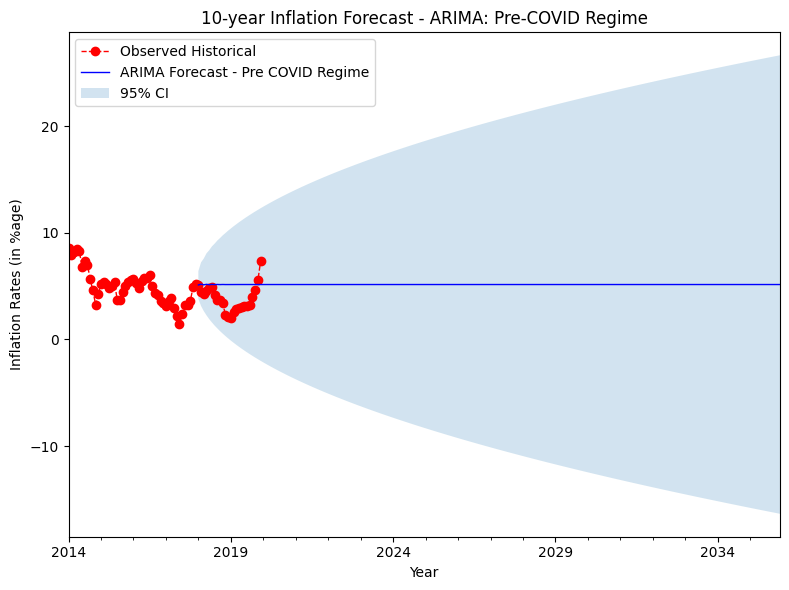

In [7]:
# Generate model
train_data = df_seasonality_test_data_pre[
    df_seasonality_test_data_pre.index.year<2018
]
test_data = df_seasonality_test_data_pre[
    df_seasonality_test_data_pre.index.year==2019
    ]
arima_model_pre = ARIMA(train_data['Inflation_rates'], order=(1,1,1))
arima_model_pre_fit = arima_model_pre.fit(cov_type='robust')
arima_model_pred = arima_model_pre_fit.get_forecast(steps=len(test_data)).predicted_mean
rmse_pre = root_mean_squared_error(test_data['Inflation_rates'], arima_model_pred)
mae_pre = mean_absolute_error(test_data['Inflation_rates'], arima_model_pred)
print(f'Pre-COVID Regime ARIMA RMSE: {rmse_pre}')
print(f'Pre-COVID Regime ARIMA MAE: {mae_pre}')
print(f'Summary statistics:\n{arima_model_pre_fit.summary()}')
is_stationary_pre = np.all(np.abs(arima_model_pre_fit.arroots)>1)
is_invertible_pre = np.all(np.abs(arima_model_pre_fit.maroots)>1)
print(f'Stability result: {is_stationary_pre}')
print(f'Invertability results: {is_invertible_pre}')


# Forecast till 2035
forecast_pre = arima_model_pre_fit.get_forecast(steps=216)
forecast_df_pre = forecast_pre.summary_frame(alpha=0.05)

# Predicted Mean, Standard Error and CI values
df_prediction_data_pre = forecast_df_pre[['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']]
df_prediction_data_pre.index.name = 'Period'
df_prediction_data_pre.to_csv(forecast_pre_dataset)

# Plot Forecast
forecast_df_pre.index = pd.to_datetime(forecast_df_pre.index, errors='coerce')
fig_forecast_pre, ax_forecast_pre = plt.subplots(figsize=(8, 6), dpi=100)
series_pre.plot(ax=ax_forecast_pre, label='Observed Historical', 
                lw=1, color='red', 
                linestyle='--', marker='o')
forecast_df_pre['mean'].plot(ax=ax_forecast_pre, 
                             label='ARIMA Forecast - Pre COVID Regime', 
                             lw=1, 
                             color='blue')
ax_forecast_pre.fill_between(forecast_df_pre.index, 
                             forecast_df_pre['mean_ci_lower'], 
                             forecast_df_pre['mean_ci_upper'], 
                             alpha=0.2, 
                             label='95% CI')
ax_forecast_pre.set_xlabel('Year')
ax_forecast_pre.set_ylabel('Inflation Rates (in %age)')
ax_forecast_pre.set_title('10-year Inflation Forecast - ARIMA: Pre-COVID Regime')
ax_forecast_pre.legend()
plt.tight_layout()
plt.show()

**CONCLUSION**

To generate a forecast with minimal variance, the following iterations of the ARIMA model were analyzed:
1. **$p=2, d=1, q=1$:** log-likelihood = -67, but MLE failed to converge. Despite AIC=144, BIC=155, we exclude this model due to non-convergence/identification issues in MLE.
2. **$p=1, d=1, q=1$:** log-likelihood = -48 (highest), AIC = 102 (lowest), BIC = 108 (lowest). No reported MLE convergence issues. Variance between observed and forecasted values = 52%.
3. **$p=1, d=0, q=1$:** log-likelihood = -68, AIC = 145 and BIC = 154 (slightly worse than (1,1,1)). No reported MLE convergence issues.

**Key Takeaway:** Even with statistical significance, the model DOES NOT generate economically accurate forecasts. This is attributed to a short fall in the training dataset. Since we are operating on a short, low-volatility, mean reverting regime, the model is succeptible to:
1. Low volatility
2. No upward trend
3. No structural shocks
4. No strong seasonality
This goes on to emphasize the role data has to play in generating usable forecasts. While our model produces statistically significant results, it is completely un-usable in real-world contexts. In the subsequent section, we shall use the entire dataset to see how a dataset that combines both post and pre-COVID regimes influences model selection and result accuracy.

### **4.2. 10-year Forecast: Pre and Post-COVID Regime**
Building on the foundations laid in the previous sections of this paper, this section focuses on performing a 10-year forecast using the combined pre and post-COVID regime data. Since we have missing values for the period of 2020 and 2021, traditional ARIMA will not fit the data. Hence, the following 3 approaches will be adopted to determine the RMSE and MAE for each and the approach with the lowest RMSE and MAE (as well as the highest Log-Likelihood and lowest AIC/ BIC) shall be adopted for forecasts.

1. ARIMA (with imputed data).
2. SARIMA - Regardless of the findings from seasonality tests, we will still pursue SARIMA for comparison purposes.
3. XGBoost - Extreme Gradient Boosting is a high-performance, regularized ML algorithm that has known to outperform traditional time-series models and hence, is being considered as an approach for comparisons. 

#### **4.2.1 Imputing the data**
This section focuses on imputing the missing data for the periods of 2020 and 2021 (using STL imputation).

Original inflation dataset:
       Date  CPI_Inflation_YoY_Percent
0  1/1/2014                       8.60
1  2/1/2014                       7.88
2  3/1/2014                       8.25
3  4/1/2014                       8.48
4  5/1/2014                       8.33
Revised inflation dataset - after setting date as index:
            CPI_Inflation_YoY_Percent
Date                                 
2014-01-01                       8.60
2014-02-01                       7.88
2014-03-01                       8.25
2014-04-01                       8.48
2014-05-01                       8.33


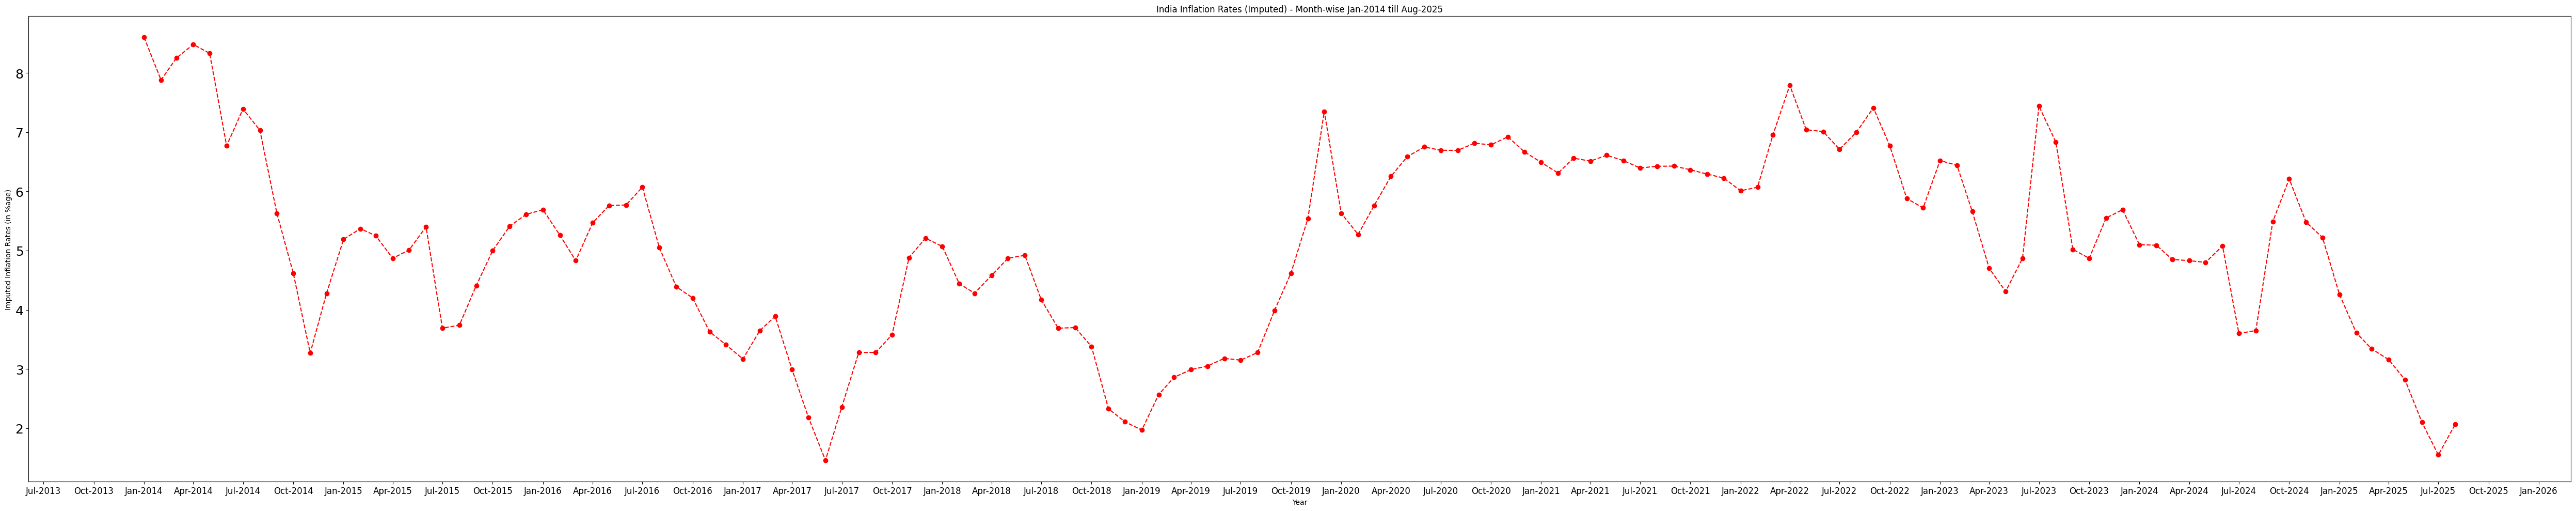

In [8]:
# Viewing the original dataset.
print(f'Original inflation dataset:\n{df_inflation.head(5)}')
df_inflation['Date'] = pd.to_datetime(df_inflation['Date'])

# Setting date as index, converting to monthly frequency and generating time interpolated data.
df_inflation_imputed = pd.DataFrame(df_inflation)
df_inflation_imputed.set_index('Date', inplace=True)
df_inflation_imputed = df_inflation_imputed.asfreq('MS')
df_inflation_imputed = df_inflation_imputed.sort_index()
print(f'Revised inflation dataset - after setting date as index:\n{df_inflation_imputed.head(5)}')
date_tmp = df_inflation_imputed['CPI_Inflation_YoY_Percent'].interpolate(method='time') # Interpolating the data to capture structure.

# Imputing missing values using STL.
stl = STL(date_tmp, period=12, robust=True).fit() # Performing seasonal decomposition on interpolated data.
trend, seasonality = stl.trend, stl.seasonal
fill_values = trend + seasonality
df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'] = df_inflation_imputed['CPI_Inflation_YoY_Percent'].fillna(fill_values)

# Plotting the data
X_series = df_inflation_imputed.index
Y_series = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed']
fig, ax = plt.subplots(figsize=(50, 10), dpi=100)
ax.plot(X_series, Y_series, '--', color='red', marker='o')
ax.set_title('India Inflation Rates (Imputed) - Month-wise Jan-2014 till Aug-2025')
ax.set_xlabel('Year')
ax.set_ylabel('Imputed Inflation Rates (in %age)')
ax.set_xticks(X_series)
ax.set_yticks(Y_series)
ax.xaxis.set_major_locator(mdates.MonthLocator([1, 4, 7, 10]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=18)
fig.tight_layout()
plt.show()


The graph above plots the imputed inflation rate data for the periods of 2020 and 2021 (along with the pre-existing data for 2014-19 and 2022-25). The imputation is executed using STL (and not standard methods of forward/ back fill) to ensure that the effect of seasonality is baked into the missing periods.

#### **4.2.2. ARIMA (with imputed data)**

This section focuses on re-fitting the ARIMA model (using imputed data for 2020 and 2021 periods) to observe changes to RMSE, MAE, Log-Likelihood, AIC and BIC outcomes. In line with the approach adopted in the above sections, we will perform STL (with Hyndman), ACF and CH-tests again on the imputed data.

Seasonality decomposition and Hyndman Seasonality Strength Score


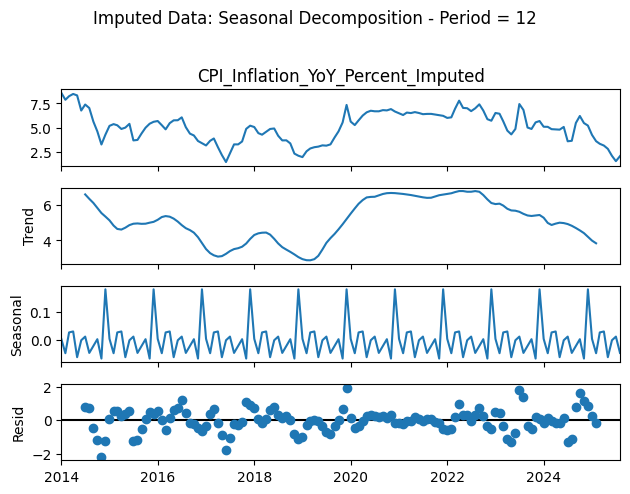

Hyndman Strength Score of Imputed Data: 0.0664
Low seasonality strength in data.
ACF plot of imputed data for visual assessment of seasonality


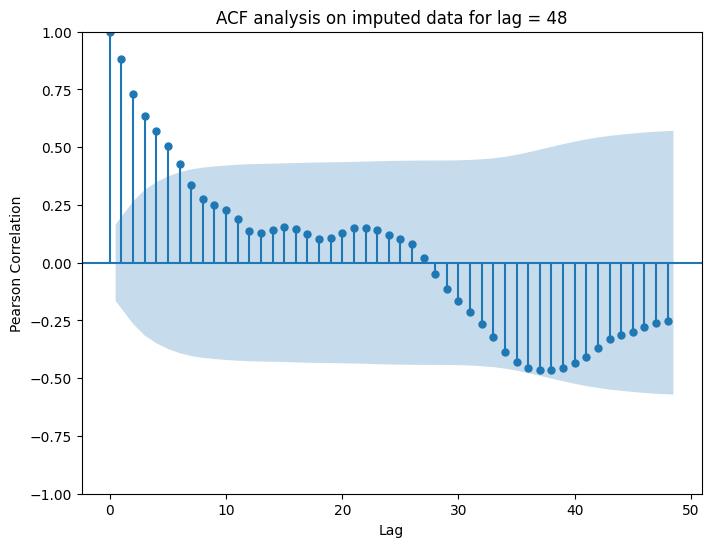

Similar to conclusion from Hyndman, ACF corroborates the fact that there is a very low presence of seasonality in the data.
The data however, does depict a non-stationary trend and this will have to be accounted for during model training.
The final CH-test will give conclusive evidence of whether seasonal differencing is warranted in the data.

Cannova-Hansen test on imputed data to determine seasonal differencing:
Result of Cannova-Hansen Test on Imputed Data:

Estimated differencing value: 0 | Seasonal Differencing Not Needed.

Data preparation, model training and comparison with pre-COVID data:
Imputed Data RMSE - 2014 to 2025: 1.4780665500800052
Imputed Data MAE - 2014 to 2025: 1.305728719447432
Comparison of pre-COVID regime v/s imputed data errors:


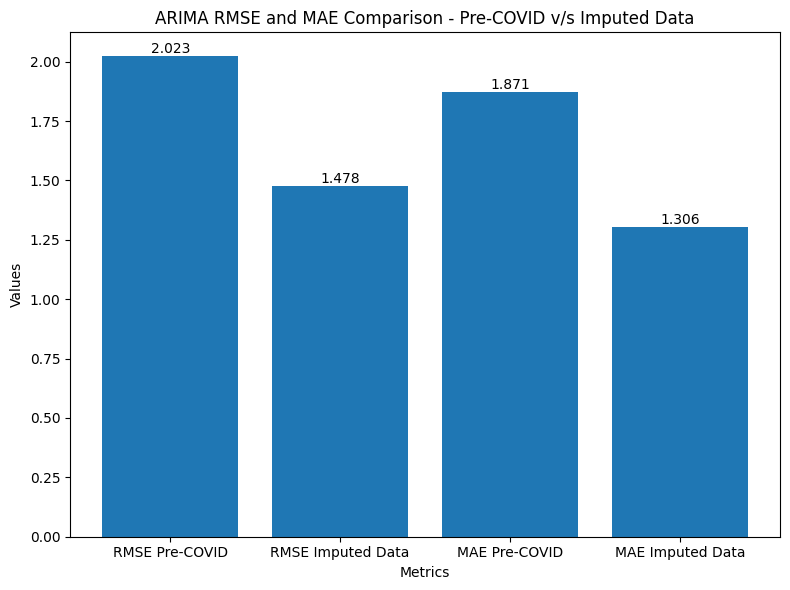

As evident from the plot above, imputing the data for periods of 2020 and 2021 reduced both RMSE and MAE errors.
Summary Statistics:
                                       SARIMAX Results                                       
Dep. Variable:     CPI_Inflation_YoY_Percent_Imputed   No. Observations:                  128
Model:                                ARIMA(1, 1, 1)   Log Likelihood                -123.004
Date:                               Wed, 26 Nov 2025   AIC                            252.007
Time:                                       14:47:31   BIC                            260.540
Sample:                                   01-01-2014   HQIC                           255.474
                                        - 08-01-2024                                         
Covariance Type:                              robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

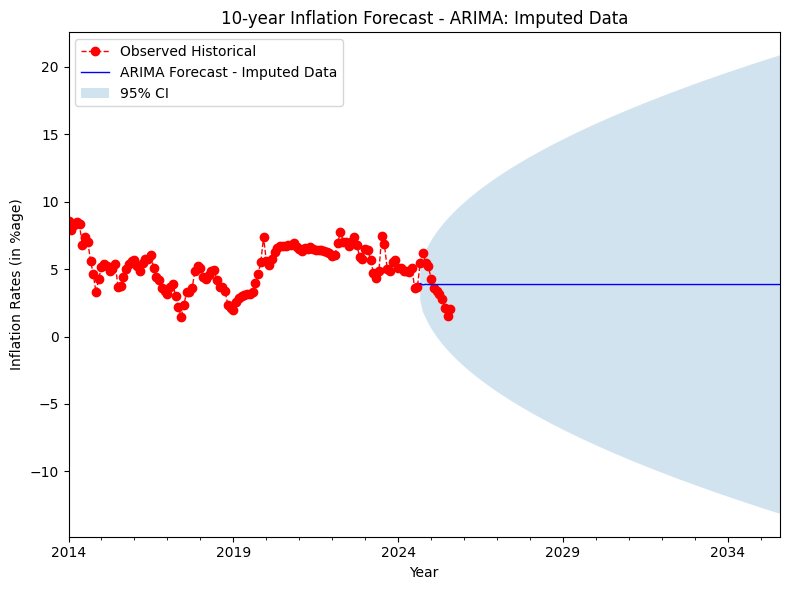

In [9]:
# Seasonal Decomposition
print('Seasonality decomposition and Hyndman Seasonality Strength Score')
seasonal_decompose_imputed = seasonal_decompose(
    df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'],
    model='additive',
    period=12
)
fig_imputed = seasonal_decompose_imputed.plot()
fig_imputed.suptitle('Imputed Data: Seasonal Decomposition - Period = 12',
                     fontsize=12,
                     y=1.02)
fig_imputed.tight_layout()
plt.show()

# Hyndman Strength Calculation
stl_imputed = STL(
    df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'],
    period=12,
    robust=True
).fit()
trend_imp, seasonality_imp, residual_imp = stl_imputed.trend, stl_imputed.seasonal, stl_imputed.resid
strength_imp = max(
    0, 
    (1 - (residual_imp.var()/(
        residual_imp.var()+seasonality_imp.var()+2*(residual_imp.cov(seasonality_imp))
        )))
    )
print(f'Hyndman Strength Score of Imputed Data: {strength_imp:.4f}')
if strength_imp > 0 and strength_imp <= 0.3:
    print(f'Low seasonality strength in data.')
else:
    print(f'High seasonality strength in data.')

# ACF Plot of Imputed Data
print('====================================================================')
print('ACF plot of imputed data for visual assessment of seasonality')
fig_imputed_acf, ax_imputed_acf = plt.subplots(figsize=(8 , 6), dpi=100)
plot_imputed_acf = plot_acf(
    df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'],
    lags=48,
    ax=ax_imputed_acf
)
ax_imputed_acf.set_title('ACF analysis on imputed data for lag = 48')
ax_imputed_acf.set_xlabel('Lag')
ax_imputed_acf.set_ylabel('Pearson Correlation')
plt.show()
print("""Similar to conclusion from Hyndman, ACF corroborates the fact that there is a very low presence of seasonality in the data.
The data however, does depict a non-stationary trend and this will have to be accounted for during model training.
The final CH-test will give conclusive evidence of whether seasonal differencing is warranted in the data.\n""")

# Cannova-Hansen Test for Seasonal Differencing
print('====================================================================')
print('Cannova-Hansen test on imputed data to determine seasonal differencing:')
imputed_inflation_data = df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'].astype('float64').to_numpy()
ch_imputed = CHTest(m=12)
D_imputed = ch_imputed.estimate_seasonal_differencing_term(imputed_inflation_data)
print('Result of Cannova-Hansen Test on Imputed Data:')
if D_imputed > 1:
    print(f"""
Estimated differencing value: {D_imputed} | Seasonal Differencing Needed.
""")
else:
    print(f"""
Estimated differencing value: {D_imputed} | Seasonal Differencing Not Needed.
""")
    
# Training and Testing Data Preparation
train_imputed_data = df_inflation_imputed[
    (df_inflation_imputed.index >= '2014-01-01') & (df_inflation_imputed.index <= '2024-08-01')
]
test_imputed_data = df_inflation_imputed[
    df_inflation_imputed.index > '2024-08-01'
]

# Training the ARIMA model on Imputed Data and Calculating Errors
print('====================================================================')
print('Data preparation, model training and comparison with pre-COVID data:')
model_arima_imputed = ARIMA(train_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], order=(1, 1, 1)).fit(cov_type='robust')
model_arima_imputed_pred = model_arima_imputed.get_forecast(steps=12).predicted_mean
model_arima_imputed_rmse = root_mean_squared_error(test_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], model_arima_imputed_pred)
model_arima_imputed_mae = mean_absolute_error(test_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], model_arima_imputed_pred)
print(f'Imputed Data RMSE - 2014 to 2025: {model_arima_imputed_rmse}')
print(f'Imputed Data MAE - 2014 to 2025: {model_arima_imputed_mae}')
print('Comparison of pre-COVID regime v/s imputed data errors:')
Y_comp_values = [rmse_pre, model_arima_imputed_rmse, mae_pre, model_arima_imputed_mae]
X_comp_values = ['RMSE Pre-COVID', 'RMSE Imputed Data', 'MAE Pre-COVID', 'MAE Imputed Data']
plt.subplots(figsize=(8, 6), dpi=100)
bars = plt.bar(X_comp_values, Y_comp_values)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('ARIMA RMSE and MAE Comparison - Pre-COVID v/s Imputed Data', fontsize=12)
plt.tight_layout()
plt.show()
print(f'As evident from the plot above, imputing the data for periods of 2020 and 2021 reduced both RMSE and MAE errors.')
print(f'Summary Statistics:\n{model_arima_imputed.summary()}')
imp_is_stationary = np.all(np.abs(model_arima_imputed.arroots) > 1)
imp_is_invertible = np.all(np.abs(model_arima_imputed.maroots) > 1)
print(f'Stability result: {imp_is_stationary}')
print(f'Invertability result: {imp_is_invertible}')

# Generating Forecast Based on Imputed Data.
print('====================================================================')
print('Generating 10-year forecast based on imputed dataset:')
model_arima_imputed_forecast = model_arima_imputed.get_forecast(steps=132)
model_arima_imputed_forecast_summary = model_arima_imputed_forecast.summary_frame(alpha=0.05)
df_prediction_data_imp = model_arima_imputed_forecast_summary[['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']]
df_prediction_data_imp.index.name = 'Period'
df_prediction_data_imp.to_csv(forecast_imputed_dataset)
model_arima_imputed_forecast.index = pd.to_datetime(model_arima_imputed_forecast_summary.index, errors='coerce')
fig_forecast_imp, ax_forecast_imp = plt.subplots(figsize=(8, 6), dpi=100)
df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'].plot(ax=ax_forecast_imp, label='Observed Historical', 
                lw=1, color='red', 
                linestyle='--', marker='o')
model_arima_imputed_forecast_summary['mean'].plot(ax=ax_forecast_imp, 
                             label='ARIMA Forecast - Imputed Data', 
                             lw=1, 
                             color='blue')
ax_forecast_imp.fill_between(model_arima_imputed_forecast_summary.index, 
                             model_arima_imputed_forecast_summary['mean_ci_lower'], 
                             model_arima_imputed_forecast_summary['mean_ci_upper'], 
                             alpha=0.2, 
                             label='95% CI')
ax_forecast_imp.set_xlabel('Year')
ax_forecast_imp.set_ylabel('Inflation Rates (in %age)')
ax_forecast_imp.set_title('10-year Inflation Forecast - ARIMA: Imputed Data')
ax_forecast_imp.legend()
plt.tight_layout()
plt.show()


**CONCLUSION**

To generate a forecast with minimal variance, the following iterations of the ARIMA model were analyzed:
1. **$p=1, d=0, q=1$:** log-likelihood = -122 (highest), AIC = 252, BIC = 263. p-values for this combination were 0.000 (AR(1)): Significant and 0.001 (MA(1)): Significant. But similar performance on RMSE and MAE metrics compared to Pre-COVID regime.
2. **$p=1, d=1, q=1$:** log-likelihood = -123 (2nd highest), AIC = 252 (same as 1), BIC = 261 (lowest). p-values for this combination were 0.222 (AR(1)): Not Significant and 0.007 (MA(1)): Significant. Much better performance on RMSE and MAE metrics compared to Pre-COVID regime.
3. **$p=0, d=0, q=1$:** log-likelihood = -173 (lowest), AIC = 353 and BIC = 356 (highest). p-values for this combination were 0.000 (MA(1)): Significant. Worse performance on RMSE and MAE compared to Pre-COVID regime.

**Key Takeaway:** While the imputed data performs poorer compared to the Pre-COVID regime in terms of statistical model fit (high AIC and BIC suggest a low in-sample fit quality), the model generates significantly better out-of-sample forecasts. The reduced statistical fit is expected, as STL imputation smooths the missing segments and the larger sample size (128 observations vs. 48 in the Pre-COVID regime) increases the information-criterion penalties. Additional comparisons with SARIMA (even though tests suggest low seasonality strength) and XGBoost on the same data set will allow us to better assess the out-of-sample forecasts generated by the imputed ARIMA model.

#### **4.2.3. SARIMA (with imputed data)**

This section focuses on fitting a SARIMA model (using imputed data for 2020 and 2021 periods) to observe changes to RMSE, MAE, Log-Likelihood, AIC and BIC outcomes. While seasonality strength tests have conclusively established that SARIMA is not warranted for this dataset, we will still proceed to test the data with SARIMA to observe changes to both in-sample and out-of-sample values to gauge how strong/weak/constant SARIMA performs - when compared to ARIMA. Since seasonality tests have already been performed on the imputed data in the above section, we shall not repeat the same here.

SARIMA extends ARIMA by incorporating seasonal components — specifically, seasonal differencing, seasonal autoregressive terms, and seasonal moving-average terms. While ARIMA captures short-run temporal dependence through AR, MA, and differencing terms, SARIMA additionally models recurring seasonal patterns using 
$s$-period lags (e.g., $Y_t - Y(t-12)$). Seasonal differencing ($Y_t - Y(t-s)$) is applied only when the data shows statistically significant seasonality. Therefore, while based on our tests for seasonality strength tests, we do not expect SARIMA to inherently perform better than ARIMA; the purpose of this section is to empirically test this hypothesis and determine whether incorporating seasonal structure improves the model’s in-sample fit and out-of-sample forecasting accuracy for this dataset.

#### **About SARIMA:**

SARIMA (Seasonal AutoRegressive Integrated Moving Average) is an extension of ARIMA used when the time-series exhibits both trend and seasonality. A model is considered a seasonal time-series model when it satisfies the following three conditions:

- The model explicitly depends on time ordering – i.e., the model uses past values to predict future outcomes.
- The model captures temporal dependence – i.e., persistence, autocorrelation, and recurring seasonal patterns (e.g., yearly cycles for monthly data).
- The model forecasts future values by extrapolating both non-seasonal and seasonal time-based relationships.

Just like ARIMA, SARIMA does not directly forecast the level of a variable. It first makes the data stationary by removing trend (non-seasonal differencing) and then removes seasonality (seasonal differencing). Once stationarity is achieved, the AR, MA, SAR (Seasonal AutoRegressive), and SMA (Seasonal Moving Average) components model the pattern of changes. These predicted changes are then added to the most recent actual value to produce forecasts.

**Additional Note – Difference between ARIMA and SARIMA:** In ARIMA, differencing removes trend using month-on-month changes (i.e., $Y_t - Y_{t-1}$). In SARIMA, an additional seasonal differencing is applied using values from the same season in the previous year (i.e., $Y_t - Y_{t-12}$ for monthly data). Thus, SARIMA accounts for recurring seasonal structure on top of ARIMA.


**The SARIMA model comprises six components (3 non-seasonal + 3 seasonal):**



##### **1. AR (AutoRegressive – Non-seasonal):**  
This component uses linear stochastic regression to model the predicted value as a linear combination of its past non-seasonal values. This component is determined using **p** in the SARIMA model input.

 - **Equation:**
    $$
    Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \varepsilon_t
    $$

    where:

    $Y_t$ = current value (e.g., inflation at time t)

    $c$ = constant (intercept) – determined using MLE

    $\phi_i$ = autoregressive coefficients – determined using MLE

    $\varepsilon_t$ = white noise (random error)



##### **2. I (Integrated – Non-seasonal):**  
This component removes non-seasonal trend from the data and makes the series stationary. It is determined using **d** in the SARIMA model input.

 - **Conditions:**
    
    If $d = 1$ (linear trend):

    $$
    \nabla Y_t = Y_t - Y_{t-1}
    $$

    If $d = 2$ (quadratic trend):

    $$
    \nabla^2 Y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) = Y_t - 2Y_{t-1} + Y_{t-2}
    $$

    where:

    $Y_t$ = current value  
    $Y_{t-1}$, $Y_{t-2}$ = previous values



##### **3. MA (Moving Average – Non-seasonal):**  
This component models the predicted value as a linear combination of past non-seasonal errors. It is determined using **q** in the SARIMA model input.

 - **Equation:**
    $$
    Y_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q}
    $$

    where:

    $\varepsilon_t$ = white noise error

    $c$ = constant (intercept)

    $\theta_i$ = moving average coefficients – determined using MLE



##### **Seasonal Components (Applied at lag $s$, e.g., $s = 12$ for monthly data):**



##### **4. SAR (Seasonal AutoRegressive):**  
This component models the predicted value using past values from the same season in previous cycles. It is determined using **P** in the SARIMA model input.

 - **Equation:**
    $$
    Y_t = c + \Phi_1 Y_{t-s} + \Phi_2 Y_{t-2s} + \dots + \Phi_P Y_{t-Ps} + \varepsilon_t
    $$

    where:

    $s$ = seasonal period (e.g., 12)

    $\Phi_i$ = seasonal autoregressive coefficients



##### **5. SI (Seasonal Integrated – Seasonal differencing):**  
This component removes seasonal patterns by differencing at lag $s$. It is determined using **D** in the SARIMA model input.

 - **Conditions:**
    
    If $D = 1$:

    $$
    \nabla_s Y_t = Y_t - Y_{t-s}
    $$

    If $D = 2$:

    $$
    \nabla_s^2 Y_t = (Y_t - Y_{t-s}) - (Y_{t-s} - Y_{t-2s}) 
                = Y_t - 2Y_{t-s} + Y_{t-2s}
    $$

    where:

    $s$ = seasonal period  
    $Y_{t-s}$, $Y_{t-2s}$ = seasonal lagged values



##### **6. SMA (Seasonal Moving Average):**  
This component models the predicted value as a combination of past seasonal shocks (errors spaced $s$ periods apart). It is determined using **Q**.

 - **Equation:**
    $$
    Y_t = c + \varepsilon_t + \Theta_1 \varepsilon_{t-s} + \Theta_2 \varepsilon_{t-2s} + \dots + \Theta_Q \varepsilon_{t-Qs}
    $$

    where:

    $\Theta_i$ = seasonal moving average coefficients – determined using MLE



##### **How it all comes together:**  

A SARIMA model is written as:

$$
SARIMA(p,d,q)(P,D,Q)_s
$$

After applying both non-seasonal differencing ($\nabla$) and seasonal differencing ($\nabla_s$), the combined model becomes:

$$
\nabla^d \nabla_s^D Y_t
= c 
+ \phi_1 (\nabla^d \nabla_s^D Y_{t-1})
+ \Phi_1 (\nabla^d \nabla_s^D Y_{t-s})
+ \varepsilon_t
+ \theta_1 \varepsilon_{t-1}
+ \Theta_1 \varepsilon_{t-s}
$$

where:

$c$ = constant (intercept) – determined using MLE  
$\phi_i$ = autoregressive coefficients  
$\theta_i$ = moving average coefficients  
$\Phi_i$ = seasonal autoregressive coefficients  
$\Theta_i$ = seasonal moving average coefficients  
$\varepsilon_t$ = white noise error  

This structure allows SARIMA to capture trend, irregular variation, and recurring seasonal cycles in a unified model.


Model training and comparison with imputed and pre-COVID data:
Imputed Data RMSE (SARIMA model) - 2014 to 2025: 1.3478054845673755
Imputed Data MAE (SARIMA model) - 2014 to 2025: 1.1808925534504977
Comparison of SARIMA v/s pre-COVID regime v/s imputed data errors:


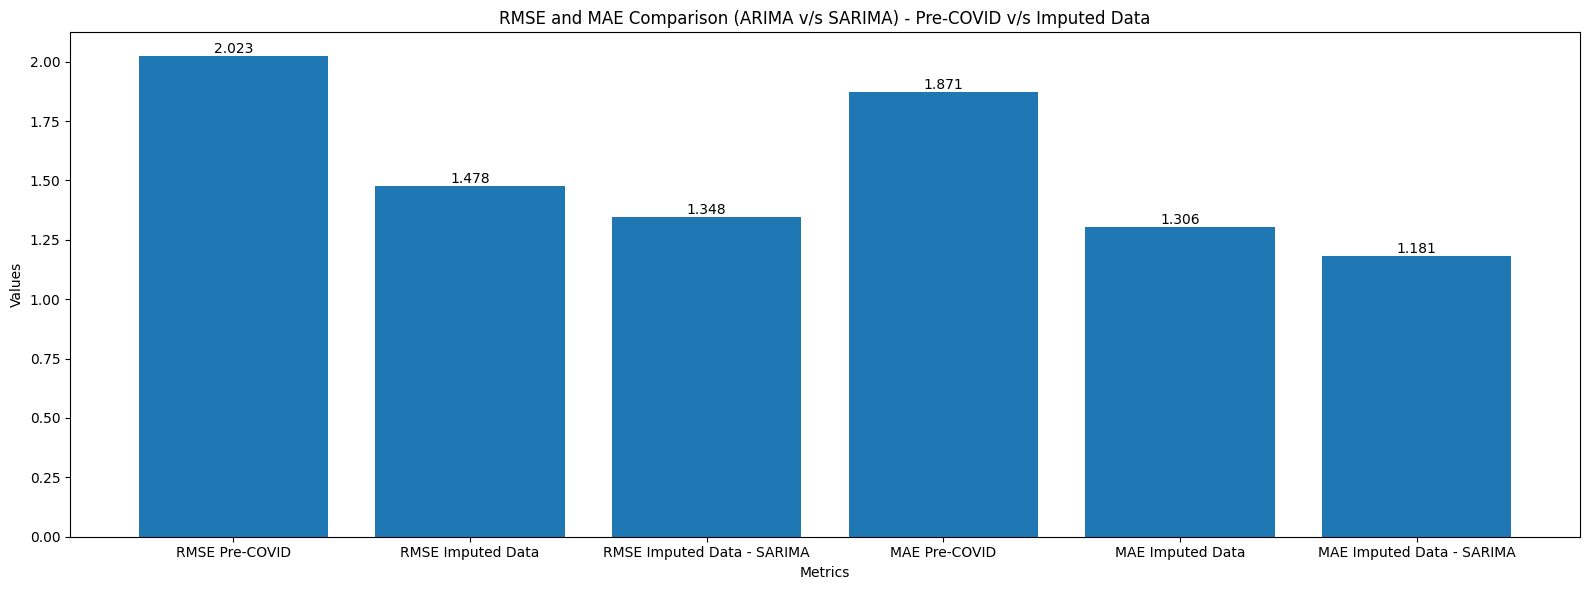

As evident from the plot above, leveraging SARIMA marginally improves out-of-sample errors.
Summary Statistics:
                                       SARIMAX Results                                       
Dep. Variable:     CPI_Inflation_YoY_Percent_Imputed   No. Observations:                  128
Model:                 SARIMAX(1, 1, 1)x(1, 1, 1, 2)   Log Likelihood                -117.720
Date:                               Wed, 26 Nov 2025   AIC                            245.440
Time:                                       14:47:31   BIC                            259.419
Sample:                                   01-01-2014   HQIC                           251.117
                                        - 08-01-2024                                         
Covariance Type:                              robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

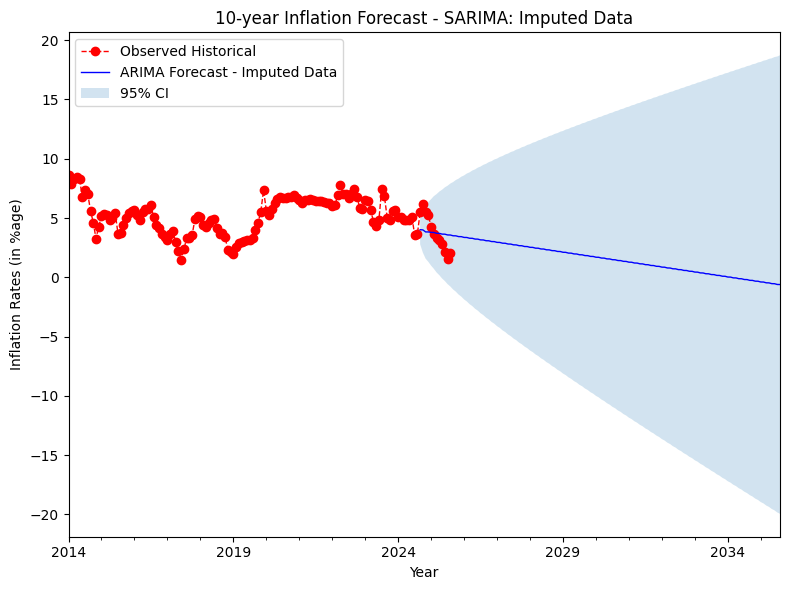

In [10]:
# Training SARIMA model on Imputed Data and Calculating Errors
print('====================================================================')
print('Model training and comparison with imputed and pre-COVID data:')
model_sarima_imputed = SARIMAX(
    train_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], 
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 2), # setting length of seasonal cycle (s) = 2
    enforce_invertibility=False,
    enforce_stationarity=False
).fit(cov_type='robust')
model_sarima_imputed_pred = model_sarima_imputed.get_forecast(steps=12).predicted_mean
model_sarima_imputed_rmse = root_mean_squared_error(test_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], model_sarima_imputed_pred) 
model_sarima_imputed_mae = mean_absolute_error(test_imputed_data['CPI_Inflation_YoY_Percent_Imputed'], model_sarima_imputed_pred) 
print(f'Imputed Data RMSE (SARIMA model) - 2014 to 2025: {model_sarima_imputed_rmse}')
print(f'Imputed Data MAE (SARIMA model) - 2014 to 2025: {model_sarima_imputed_mae}')
print('Comparison of SARIMA v/s pre-COVID regime v/s imputed data errors:')
Y_comp_values_SARIMA = [rmse_pre, model_arima_imputed_rmse, model_sarima_imputed_rmse, mae_pre, model_arima_imputed_mae, model_sarima_imputed_mae]
X_comp_values_SARIMA = ['RMSE Pre-COVID', 'RMSE Imputed Data', 'RMSE Imputed Data - SARIMA', 'MAE Pre-COVID', 'MAE Imputed Data', 'MAE Imputed Data - SARIMA']
plt.subplots(figsize=(16, 6), dpi=100)
bars = plt.bar(X_comp_values_SARIMA, Y_comp_values_SARIMA)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center', 
        va='bottom',
        fontsize=10
    )
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RMSE and MAE Comparison (ARIMA v/s SARIMA) - Pre-COVID v/s Imputed Data', fontsize=12)
plt.tight_layout()
plt.show()
print(f'As evident from the plot above, leveraging SARIMA marginally improves out-of-sample errors.')
print(f'Summary Statistics:\n{model_sarima_imputed.summary()}')

# Generating Forecast Based on Imputed Data.
print('====================================================================')
print('Generating 10-year forecast based on imputed dataset:')
model_sarima_imputed_forecast = model_sarima_imputed.get_forecast(steps=132)
model_sarima_imputed_forecast_summary = model_sarima_imputed_forecast.summary_frame(alpha=0.05)
df_prediction_data_sarima_imp = model_sarima_imputed_forecast_summary[['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']]
df_prediction_data_sarima_imp.index.name = 'Period'
df_prediction_data_sarima_imp.to_csv(sarima_forecast_imputed_dataset)
model_sarima_imputed_forecast_summary.index = pd.to_datetime(model_sarima_imputed_forecast_summary.index, errors='coerce')
fig_forecast_imp, ax_forecast_imp = plt.subplots(figsize=(8, 6), dpi=100)
df_inflation_imputed['CPI_Inflation_YoY_Percent_Imputed'].plot(ax=ax_forecast_imp, label='Observed Historical', 
                lw=1, color='red', 
                linestyle='--', marker='o')
model_sarima_imputed_forecast_summary['mean'].plot(ax=ax_forecast_imp, 
                             label='ARIMA Forecast - Imputed Data', 
                             lw=1, 
                             color='blue')
ax_forecast_imp.fill_between(model_sarima_imputed_forecast_summary.index, 
                             model_sarima_imputed_forecast_summary['mean_ci_lower'], 
                             model_sarima_imputed_forecast_summary['mean_ci_upper'], 
                             alpha=0.2, 
                             label='95% CI')
ax_forecast_imp.set_xlabel('Year')
ax_forecast_imp.set_ylabel('Inflation Rates (in %age)')
ax_forecast_imp.set_title('10-year Inflation Forecast - SARIMA: Imputed Data')
ax_forecast_imp.legend()
plt.tight_layout()
plt.show()

**CONCLUSION**

In conjunction with the ARIMA model above, and to conduct an apple to apple comparison, only one iteration of the SARIMA model was applied:
1. **$p=1, d=1, q=1, P=1, D=1, Q=1, s=2$:** log-likelihood = -118 (marginally better compared to ARIMA performance), AIC = 245, BIC = 260. p-values for this combination suggest "No Significance" across the board - meaning that the estimated model coefficients are basically noise and do not contribute anything meaningful in explaining variability in the data.


**Key Takeaway:** Although all diagnostics suggested that SARIMA is not warranted for the dataset, the model's out-of-sample performance is better than ARIMA (on the same dataset). Also, while the model also performs better in some of the in-sample parameters (higher log-likelihood: -118 v/s -123, lower AIC and BIC: 245/260 v/s 252/261) it fails to describe the data with any statistical significance. This performance is attributed to SARIMA's inherent advantage over ARIMA in terms of flexibility - SARIMA operates with more parameters as compared to ARIMA. 
Our comparison between SARIMA and ARIMA highlights a key point on model selection - **Intent of the Model**. In simple terms, if the intent is to describe variability in the data, choosing a model with better in-sample performance (high log-likelihood and low AIC/ BIC along with p-values that suggest Statistical Significance across model coefficients) is the right way-forward. However, if the intent is forecasting/ predictions, choosing a model with better out-of-sample performance (low RMSE and MAE) is the right way forward. In our case, while SARIMA gives a better out-of-sample performance (along with a strong degree of fit - based on log-likelihood, AIC and BIC results), using SARIMA as the go-to model to describe the data would not be a recommended course of action (due to high p-values - suggesting No Statistical Significance of the model coefficients). To describe the data, ARIMA is the better choice. However, for forecasting and prediction, SARIMA would be the better choice (due to low RMSE and MAE). Another key point to note is that both SARIMA and ARIMA include variability in their projections only up to a 1-year forecast. Long-horizon ARIMA/SARIMA forecasts converge toward a constant because differencing makes the future increments i.i.d (Independent and Identically Distributed) with zero mean. Without exogenous variables, ARIMA-type models cannot project structural economic shifts, and therefore forecasts flatten out as the horizon increases. Hence, **neither models provide structurally or macro-economically meaningful long-run forecasts**. In the next sections, we will explore XGBoost which is a well-known supervised ML model to determine how better/ poorer it performs on in-sample, out-of-sample and economic viability metrics - compared to SARIMA and ARIMA.

#### **4.2.4. XGBoost - Extreme Gradient Boosting (with imputed data) - CUDA Enabled**

This section focuses on fitting an XGBoost model (using imputed data for 2020 and 2021 periods) to observe changes to RMSE, MAE and long-run macro-economic forecast. XGBoost is a supervised, non-parametric, tree-ensemble model that often outperforms traditional statistical models due to its inherent ability to capture non-linear relationships, high-order interactions, structural breaks, and irregular dynamics without requiring assumptions of linearity, stationarity, or Gaussian errors. Since XGBoost does not optimize a likelihood-based objective, classical statistical metrics such as Log-Likelihood, AIC, and BIC are not applicable. Instead, the focus is on comparing out-of-sample forecasting accuracy (RMSE and MAE), model stability, and long-run forecast viability—relative to ARIMA and SARIMA.

In this section, we will test this assumption and provide empirical evidence to support (if true) or explain (if untrue) this expectation.

Additionally, to enable faster processing, XGBoost has been executed in a WSL (Windows Subsystem for Linux) environment which is CUDA (Compute Unified Device Architecture) enabled and allows XGBoost to leverage the power of a discrete GPU (via NVIDIA's CUDA framework) and reduce the model's training time - compared to a CPU-only environment.

**About XGBoost:**

XGBoost (Extreme Gradient Boosting) is an implementation of gradient-boosted decision trees. It builds an ensemble of weak learners (regression trees), where each successive tree attempts to correct the residual errors made by the previous ensemble.

A model is considered a machine-learning ensemble model (such as XGBoost) when it satisfies the following three conditions:

- The model does **not** rely on explicit time ordering assumptions or differencing rules; instead, time dependence is learned implicitly through lagged feature inputs.
- The model captures **non-linear and interaction effects**, including threshold effects, saturation effects, and regime changes.
- The model forecasts future values by iteratively minimizing a loss function through gradient boosting, rather than by extrapolating parametric temporal relationships.

**Key Points of Note on XGBoost:**

- XGBoost grows trees using a **depth-first, leaf-wise strategy**, where the algorithm always expands the leaf with the highest Gain value. This contrasts with breadth-first tree growth in classical CART-style algorithms, which split all nodes at the same depth before moving deeper.
- XGBoost uses depth-first growth because **leaf-wise expansion maximizes loss reduction at each step**. The algorithm greedily chooses the split that provides the largest improvement in the objective, which often occurs deeper in the tree. This produces more flexible and expressive trees, although it may increase computation compared to the simpler breadth-first splitting used in CART.
- Unlike bagging algorithms - which require samples to be generated (using SRSWR) for parallel processing - boosting algorithms do not have any such requirements. Additionally, it is recommended to **NOT** perform any sampling when using XGBoost on time-series data and instead, maintain strict chronological order - to avoid data leakage.

**XGBoost Prediction Structure:**

Unlike ARIMA/SARIMA, XGBoost does not use AR, MA, SAR, SMA, or differencing operators. Instead, its predictions follow:

$$
\hat{Y}_t = \sum_{k=1}^{K} f_k(X_t), \qquad f_k \in \mathcal{F}
$$

where:

- $X_t$ = feature vector at time $t$ (e.g., lag values: $Y_{t-1}, Y_{t-2}, \dots$)
- $K$ = number of boosted trees
- $f_k$ = kth regression tree in the model (weak learner)
- $\mathcal{F}$ = space of all possible trees


The model is trained by minimizing a regularized objective:

$$
\mathcal{L} = \sum_{t=1}^{T} \ell \left( Y_t, \hat{Y}_t \right)
\; + \;
\sum_{k=1}^{K} \Omega(f_k)
$$

where the objective includes:

1. a **training loss** term $\ell(\cdot)$, and  
2. a **regularization** term $\Omega(f_k)$ controlling model complexity.

To optimize this objective efficiently, XGBoost applies a second-order Taylor expansion of the loss around $\hat{Y}_t^{(k-1)}$.

**Key Components of XGBoost:**

**1. Ensemble of Regression Trees:**  
Each tree partitions the feature space into regions and assigns a constant value to each region. Trees capture **non-linearities** and **interaction effects** that linear time-series models cannot model.

**2. Gradient Boosting Mechanism:**  
Each tree $f_k$ partitions the feature space into $T_k$ leaf regions and assigns a constant value to each leaf.  
This enables the model to capture:

- non-linear relationships  
- threshold effects  
- interactions between lagged predictors  

that cannot be modeled using linear time-series techniques.

**2. Gradient Boosting Mechanism (Conceptual Layer):**

Classical gradient boosting fits each new tree to the **negative gradient** of the loss function evaluated at the previous prediction:

$$
g_t 
= 
\frac{\partial \ell(Y_t,\; \hat{Y}_t^{(k-1)})}{\partial \hat{Y}_t^{(k-1)}}
$$

Once $f_k$ is learned, the model prediction is updated as:

$$
\hat{Y}_t^{(k)}
=
\hat{Y}_t^{(k-1)}
+
\eta \; f_k(X_t)
$$

where:

- $\eta$ = learning rate  
- a smaller $\eta$ reduces overfitting through conservative updates  

**3. Second-Order Optimization (Actual XGBoost Implementation):**

XGBoost improves on classical gradient boosting by incorporating **second-order information**.  
A second-order Taylor expansion of the loss yields:

$$
\ell(Y_t,\; \hat{Y}_t^{(k-1)} + f_k(X_t))
\approx
\ell(Y_t,\; \hat{Y}_t^{(k-1)})
+
g_t f_k(X_t)
+
\frac{1}{2} h_t f_k(X_t)^2
$$

where:

- $g_t = \frac{\partial \ell}{\partial \hat{Y}_t}$ is the first derivative (gradient)  
- $h_t = \frac{\partial^2 \ell}{\partial \hat{Y}_t^2}$ is the second derivative (Hessian)  

Let the set of samples belonging to leaf $j$ be indexed by $t \in j$.  
Define:

$$
G_j = \sum_{t \in j} g_t,
\qquad
H_j = \sum_{t \in j} h_t
$$

Using this local quadratic approximation, XGBoost obtains the **optimal leaf weight** in closed form:

$$
w_j^{*}
=
-
\frac{G_j}{H_j + \lambda}
$$

which is the analytic minimizer of the approximated objective.

**4. Regularization (Complexity Control):**

XGBoost applies explicit regularization to penalize overly complex trees:

$$
\Omega(f_k)
=
\gamma T_k
+
\frac{1}{2} \lambda \sum_{j=1}^{T_k} w_j^2
$$

where:

- $T_k$ = number of leaves in tree $k$  
- $w_j$ = weight assigned to leaf $j$  
- $\gamma$ = penalty for adding a new leaf  
- $\lambda$ = L2 penalty on leaf weights  

This regularization controls tree depth and prevents overfitting.

**5. Split Selection (Gain Computation):**

To determine the best split, XGBoost computes the **gain** in objective reduction:

$$
\text{Gain}
=
\frac{1}{2}
\left[
\frac{G_L^2}{H_L + \lambda}
+
\frac{G_R^2}{H_R + \lambda}
-
\frac{(G_L + G_R)^2}{H_L + H_R + \lambda}
\right]
-
\gamma
$$

where:

- $G_L, H_L$ = gradient and Hessian sums for the left child  
- $G_R, H_R$ = gradient and Hessian sums for the right child  

A split is accepted only if $\text{Gain} > 0$, ensuring each split improves the objective.

**6. Feature Engineering for Time-Series:**

Since XGBoost does not inherently understand time ordering or autocorrelation, lagged features must be constructed manually:

$$
X_t
=
\left[
Y_{t-1},\;
Y_{t-2},\;
\dots,\;
Y_{t-L},\;
\text{rolling means},\;
\text{rolling volatilities},\;
\text{calendar features}
\right]
$$

where $L$ represents the chosen number of lags.  
This transforms the univariate time series into a supervised-learning dataset suitable for tree-based methods.

**7. Handling Structural Breaks and Non-Linearity:**

XGBoost naturally adapts to:

- abrupt shocks,  
- non-linear inflation dynamics,  
- structural breaks,  
- interaction effects among predictors,  

due to its ability to build trees that partition the feature space adaptively.  
This often provides improved flexibility relative to linear statistical models such as ARIMA or SARIMA.

**How it all comes together:**

The final XGBoost model can be expressed as:

$$
\hat{Y}_t
=
\sum_{k=1}^{K}
f_k
\left(
Y_{t-1}, Y_{t-2}, \dots, Y_{t-L}
\right)
$$

Each tree $f_k$ captures a small piece of the underlying pattern. When many trees are combined through gradient boosting, the model learns complex, non-linear inflation dynamics.

Unlike ARIMA/SARIMA:

- no differencing is required  
- no stationarity assumptions are needed  
- no parametric AR/MA structure is imposed  
- interactions between lags are captured automatically  
- long-run forecasts depend on recursive feeding of predicted values  

This flexibility enables XGBoost to outperform linear models in many real-world time-series forecasting applications, especially when dynamics are non-linear, noisy, or structurally unstable.

To summarize the above, XGBoost uses:

- Gradient → to determine direction
- Hessian → to determine step size and improve optimization
- Regularization → to control model complexity
- Closed-form leaf weights → instead of iterative gradient descent steps

In [11]:
# Check CUDA enablement
print(f'XGBoost version: {xgb.__version__}')
try:
    xgb.XGBRegressor(tree_method='gpu_hist')
    print(f'XGB enabled with CUDA')
except:
    print('XGB not enabled with CUDA')

# Review raw dataset
print('====================================================================')
df_xgb_inflation_dataset = df_inflation.copy()
print(f'Raw data for feature engineering:\n{df_xgb_inflation_dataset.head(5)}')
print(f'Datatypes of raw dataset columns:')
print(f'Date column data type: {df_xgb_inflation_dataset['Date'].dtype}')
print(f'CPI Inflation column data type: {df_xgb_inflation_dataset['CPI_Inflation_YoY_Percent'].dtype}')

# Perform feature engineering
print('====================================================================')


XGBoost version: 3.1.2
XGB enabled with CUDA
Raw data for feature engineering:
        Date  CPI_Inflation_YoY_Percent
0 2014-01-01                       8.60
1 2014-02-01                       7.88
2 2014-03-01                       8.25
3 2014-04-01                       8.48
4 2014-05-01                       8.33
Datatypes of raw dataset columns:
Date column data type: datetime64[ns]
CPI Inflation column data type: float64


# **End of Document**